In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch

from useful_functions_notebook_7 import *
from useful_functions_notebook_8to13 import *
from useful_functions_notebook_14to18 import *

# load model


In [106]:
class Diffusion:
    def __init__(self, T=1000, beta_start=1e-4, beta_end=0.02, img_size=64, device="cpu"):
        self.T = T
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = device
        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.T)
    
    def cosine_schedule(self, s=0.008):
        def f(t, s):
            return torch.cos((t / self.T + s) / (1 + s) * 0.5 * torch.pi) ** 2
        x = torch.linspace(0, self.T, self.T + 1)
        alphas_cumprod = f(x, s) / f(torch.tensor([0]), s)
        betas = 1 - alphas_cumprod[1:] / alphas_cumprod[:-1]
        betas = torch.clip(betas, 0.0001, 0.999)
        return betas

    def noise_images(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        Ɛ = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * Ɛ, Ɛ
    

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.T, size=(n,))

    def sample(self, model, img):
        model.eval()
        with torch.no_grad():
            x = img
            for i in tqdm.tqdm(reversed(range(1, self.T)), position=0):
                t = (torch.ones(len(x)) * i).long().to(self.device)
                predicted_noise, bottleneck = model(x, t)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        x = (x.clamp(-1, 1) + 1) / 2
        x = (x * 255).type(torch.uint8)
        return x, bottleneck

class UNet(nn.Module):
    def __init__(self, c_in=3, c_out=3, time_dim=256, device="cpu"):
        super().__init__()
        self.device = device
        self.time_dim = torch.tensor(time_dim).to(device)
        self.inc = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        self.sa1 = SelfAttention(128, 32)
        self.down2 = Down(128, 256)
        self.sa2 = SelfAttention(256, 16)
        self.down3 = Down(256, 256)
        self.sa3 = SelfAttention(256, 8)

        self.bot1 = DoubleConv(256, 512)
        self.bot2 = DoubleConv(512, 512)
        self.bot3 = DoubleConv(512, 256)

        self.up1 = Up(512, 128)
        self.sa4 = SelfAttention(128, 16)
        self.up2 = Up(256, 64)
        self.sa5 = SelfAttention(64, 32)
        self.up3 = Up(128, 64)
        self.sa6 = SelfAttention(64, 64)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        ).to(device)
        pos_enc_a = torch.sin(t.repeat(1, channels.to(device) // 2) * inv_freq).to(device)
        pos_enc_b = torch.cos(t.repeat(1, channels.to(device) // 2) * inv_freq).to(device)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t):
        
        t = t.unsqueeze(-1).type(torch.float).to(device)
        t = self.pos_encoding(t, self.time_dim)

        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)

        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)

        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.outc(x)
        return output, x4

In [107]:
T = 1000
model = UNet()

model_path = "diffusion_notebook/diffusion_2.0/diffusion_new_model2.0.pt"

saved_model = torch.load(model_path, map_location = 'cpu')
model.load_state_dict(saved_model)

diffusion = Diffusion(T, img_size=64, device=device)

transform_back = transforms.Resize((29, 10))
transform = transforms.Resize((64, 64))

In [108]:
test = five[0, 0:1]
print(test.shape)

test1 = transform(test)
print(test1.shape)

TT = torch.randint(low=1, high=T, size=(len(test1),))

test2 =  diffusion.noise_images(test1, TT)
print(test2[0].shape)

test3, bottleneck = diffusion.sample(model, test2[0].float())
print(test3[0].shape)
print(bottleneck[0].shape)

plt.imshow(test[0].permute(1, 2, 0))
plt.show()

plt.imshow(test1[0].permute(1, 2, 0))
plt.show()

plt.imshow(test2[0][0].permute(1, 2, 0))
plt.show()

torch.Size([1, 3, 29, 10])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])


5it [00:03,  1.30it/s]


KeyboardInterrupt: 

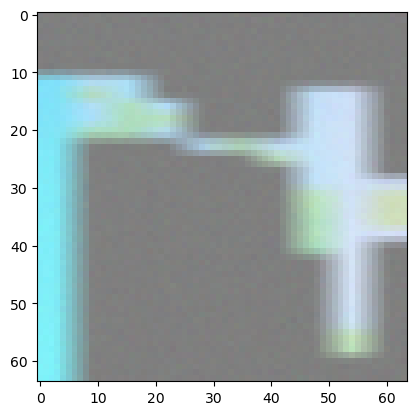

In [67]:
plt.imshow(test3[0].permute(1, 2, 0))
plt.show()

# load data

In [12]:
dataset = torch.load("data/dataset_normalized_consistent_only.pt")
one_branch = []
two_branch = []
three_branch = []
four_branch = []
five_branch = []
six_branch = []
seven_branch = []
eight_branch = []
nine_branch = []
ten_branch = []

for datapoint in dataset:
    one_channel = datapoint[1]
    branches = torch.count_nonzero(one_channel, dim=0)
    num_branch = torch.count_nonzero(branches, dim=0)
    if num_branch == 1:
        one_branch.append(datapoint)
    elif num_branch == 2:
        two_branch.append(datapoint)
    elif num_branch == 3:
        three_branch.append(datapoint)
    elif num_branch == 4:
        four_branch.append(datapoint)
    elif num_branch == 5:
        five_branch.append(datapoint)
    elif num_branch == 6:
        six_branch.append(datapoint)
    elif num_branch == 7:
        seven_branch.append(datapoint)
    elif num_branch == 8:
        eight_branch.append(datapoint)
    elif num_branch == 9:
        nine_branch.append(datapoint)
    elif num_branch == 10:
        ten_branch.append(datapoint)
        
total = [one_branch, two_branch, three_branch, four_branch, five_branch,
         six_branch, seven_branch, eight_branch, nine_branch, ten_branch]

total_im = 0
for i, branch_list in enumerate(total):
    total_im += len(branch_list)
    print(f"number of images with {i + 1} branches is: {len(branch_list)}")
    
print(f"double check that all images are counted: total images is {total_im} = {dataset.shape[0]}")

number of images with 1 branches is: 0
number of images with 2 branches is: 0
number of images with 3 branches is: 0
number of images with 4 branches is: 0
number of images with 5 branches is: 7575
number of images with 6 branches is: 8012
number of images with 7 branches is: 7138
number of images with 8 branches is: 5990
number of images with 9 branches is: 4757
number of images with 10 branches is: 3923
double check that all images are counted: total images is 37395 = 37395


# PCA

### input merger tree of size (3, 29, 10)

torch.Size([1, 256, 8, 8])
torch.Size([2, 2, 256, 8, 8])
(2, 2, 16384)


/Users/corneliusbencsik/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_pca.py:543: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/corneliusbencsik/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_pca.py:543: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


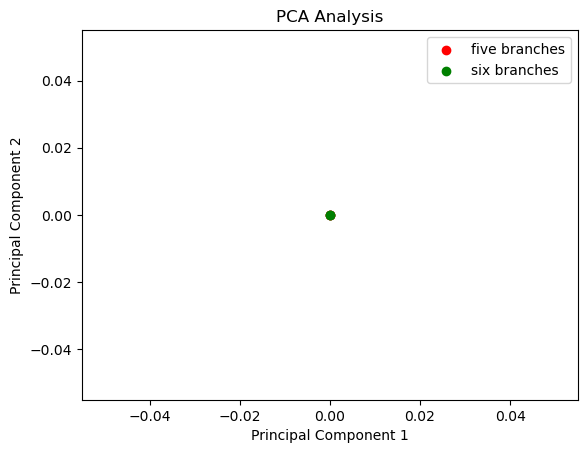

In [87]:
print(bottleneck.shape)
data1 = torch.cat([bottleneck, bottleneck], dim = 0).unsqueeze(0)
data2 = torch.cat([bottleneck, bottleneck], dim = 0).unsqueeze(0)
data = torch.cat([data1, data2], dim = 0)
print(data.shape)
data = data.view(data.shape[0], data.shape[1], -1).numpy()
print(data.shape)
pca = PCA(n_components=2) 
for i, data_set_branch in enumerate(data):
    data_pca = data_set_branch
    data_reduced = pca.fit_transform(data_pca)
    plt.scatter(data_reduced[:, 0], data_reduced[:, 1], c=colors[i], label=f'{branches[i]} branches')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Analysis')
plt.legend()
plt.show()

(6, 10, 870)


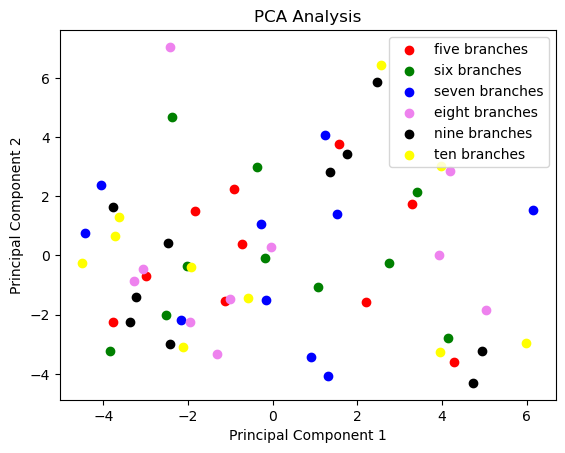

In [76]:
num_samples = 10

five = torch.stack(five_branch)[:num_samples].unsqueeze(0)
six = torch.stack(six_branch)[:num_samples].unsqueeze(0)
seven = torch.stack(seven_branch)[:num_samples].unsqueeze(0)
eight = torch.stack(eight_branch)[:num_samples].unsqueeze(0)
nine = torch.stack(nine_branch)[:num_samples].unsqueeze(0)
ten = torch.stack(ten_branch)[:num_samples].unsqueeze(0)

data = torch.cat([five, six, seven, eight, nine, ten], dim = 0)
data = data.view(data.shape[0], data.shape[1], -1).numpy()

print(data.shape)

colors = ['red', 'green', 'blue', 'violet', 'black', 'yellow']
branches = ["five", "six", "seven", "eight", "nine", "ten"]


# Perform PCA
pca = PCA(n_components=2)  # Reduce to 2 components for visualization

for i, data_set_branch in enumerate(data):
    data_pca = data_set_branch
    data_reduced = pca.fit_transform(data_pca)
    plt.scatter(data_reduced[:, 0], data_reduced[:, 1], c=colors[i], label=f'{branches[i]} branches')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Analysis')
plt.legend()
plt.show()

### latent representation of size 300

In [ ]:
five1 = transform(five[0])
TT = torch.randint(low=1, high=T, size=(num_samples,))
five2 =  diffusion.noise_images(five1, TT)
five3, bottleneck_five = diffusion.sample(model, five2[0].float())

In [ ]:
six1 = transform(six[0])
TT = torch.randint(low=1, high=T, size=(num_samples,))
six2 =  diffusion.noise_images(six1, TT)
six3, bottleneck_six = diffusion.sample(model, six2[0].float())

In [ ]:
seven1 = transform(seven[0])
TT = torch.randint(low=1, high=T, size=(num_samples,))
seven2 =  diffusion.noise_images(seven1, TT)
seven3, bottleneck_six = diffusion.sample(model, seven2[0].float())

In [ ]:


data = torch.cat([five_latent_out, six_latent_out, seven_latent_out, eight_latent_out, nine_latent_out, ten_latent_out], dim = 0)

print(data.shape)

colors = ['red', 'green', 'blue', 'violet', 'black', 'yellow']
branches = ["five", "six", "seven", "eight", "nine", "ten"]

# Perform PCA analysis
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization

for i, data_set_branch in enumerate(data):
    data_pca = data_set_branch.detach().numpy()
    data_reduced = pca.fit_transform(data_pca)
    plt.scatter(data_reduced[:, 0], data_reduced[:, 1], c=colors[i], label=f'{branches[i]} branches')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Analysis')
plt.legend()
plt.show()

# t-SNE

### input merger tree of size (3, 29, 10)

In [ ]:
num_samples = 10

data = torch.cat([five, six, seven, eight, nine, ten], dim = 0)
data = data.view(data.shape[0], data.shape[1], -1).numpy()

colors = ['red', 'green', 'blue', 'violet', 'black', 'yellow']
branches = ["five", "six", "seven", "eight", "nine", "ten"]


# Perform PCA

tsne = TSNE(n_components=2, perplexity=num_samples - 9) 

for i, data_set_branch in enumerate(data):
    data_t_sne = data_set_branch
    data_tsne = tsne.fit_transform(data_t_sne)
    plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=colors[i], label=f'{branches[i]} branches')
    
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE of Torch Tensor Data')
plt.legend()
plt.show()


### latent representation of size 300

In [ ]:
data = torch.cat([five_latent_out, six_latent_out, seven_latent_out, eight_latent_out, nine_latent_out, ten_latent_out], dim = 0)

colors = ['red', 'green', 'blue', 'violet', 'black', 'yellow']
branches = ["five", "six", "seven", "eight", "nine", "ten"]


tsne = TSNE(n_components=2, perplexity=num_samples - 9) 

for i, data_set_branch in enumerate(data):
    data_t_sne = data_set_branch.detach().numpy()
    data_tsne = tsne.fit_transform(data_t_sne)
    plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=colors[i], label=f'{branches[i]} branches')
    
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE of Torch Tensor Data')
plt.legend()
plt.show()
